In [1]:
#@title Import Modules and Constant Variables

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





# Dataset
SEISMIC_ATTRIBUTE_NAME = 'Amplitude'

# Images for training
DATA_IMAGES_PATH = os.path.abspath(os.path.join('Datasets', 'SEG2020', SEISMIC_ATTRIBUTE_NAME))
assert os.path.exists(DATA_IMAGES_PATH), "Data images path does not exist"

INLINE_DATA_IMAGES_PATH = os.path.join(DATA_IMAGES_PATH, 'Inlines')
assert os.path.exists(INLINE_DATA_IMAGES_PATH), "Inline data images path does not exist"

CROSSLINE_DATA_IMAGES_PATH = os.path.join(DATA_IMAGES_PATH, 'Crosslines')
assert os.path.exists(CROSSLINE_DATA_IMAGES_PATH), "Crossline data images path does not exist"



# Images label
LABEL_IMAGES_PATH = os.path.abspath(os.path.join('Datasets', 'SEG2020', 'Labels'))
assert os.path.exists(LABEL_IMAGES_PATH), "Label images path does not exist"

INLINE_LABEL_IMAGES_PATH = os.path.join(LABEL_IMAGES_PATH, 'Inlines')
assert os.path.exists(INLINE_LABEL_IMAGES_PATH), "Inline label images path does not exist"

CROSSLINE_LABEL_IMAGES_PATH = os.path.join(LABEL_IMAGES_PATH, 'Crosslines')
assert os.path.exists(CROSSLINE_LABEL_IMAGES_PATH), "Crossline label images path does not exist"



inline_train_range = (8, 583)
crossline_train_range = (46, 737)

inline_val_range1 = (1, 7)
inline_val_range2 = (584, 590)
crossline_val_range1 = (2, 45) # Exclude crossline 1 due to wrong label
crossline_val_range2 = (738, 782)



X_IMAGE_SIZE = (256, 240) # Resize input image into the model due to the GPU memory limitation
# Since we have 4 pooling layers, the image size should be a multiple of 16





# Hyperparameters
NUM_CLASSES = 7
EPOCHS = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1
loss_func = torch.nn.CrossEntropyLoss()





# Model saving
MODEL_PATH = 'models'

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

LATEST_MODEL_PATH = os.path.join(MODEL_PATH, 'latest.pth')
BEST_MODEL_NAME = 'unet.pth'
BEST_MODEL_PATH = os.path.join(MODEL_PATH, BEST_MODEL_NAME)





# Performance saving path
IMAGE_SIZE_DESC = f'-{str(X_IMAGE_SIZE[0])}x{str(X_IMAGE_SIZE[1])}'
ARCHITECTURE_DESC = ''
EPOCH_DESC = f'-epoch{str(EPOCHS)}'
LEARNING_RATE_DESC = f'-lr{str(LEARNING_RATE)}'
BATCH_SIZE_DESC = f'-bs{str(BATCH_SIZE)}'
ADDITIONAL_DESC = ''
PERFORMANCE_PATH = os.path.join('output', 'performance', SEISMIC_ATTRIBUTE_NAME + IMAGE_SIZE_DESC + ARCHITECTURE_DESC + EPOCH_DESC + LEARNING_RATE_DESC + BATCH_SIZE_DESC + ADDITIONAL_DESC)

if not os.path.exists(PERFORMANCE_PATH):
    os.makedirs(PERFORMANCE_PATH)

torch.Size([3, 1, 1006, 782]) torch.Size([3, 1, 1006, 782])


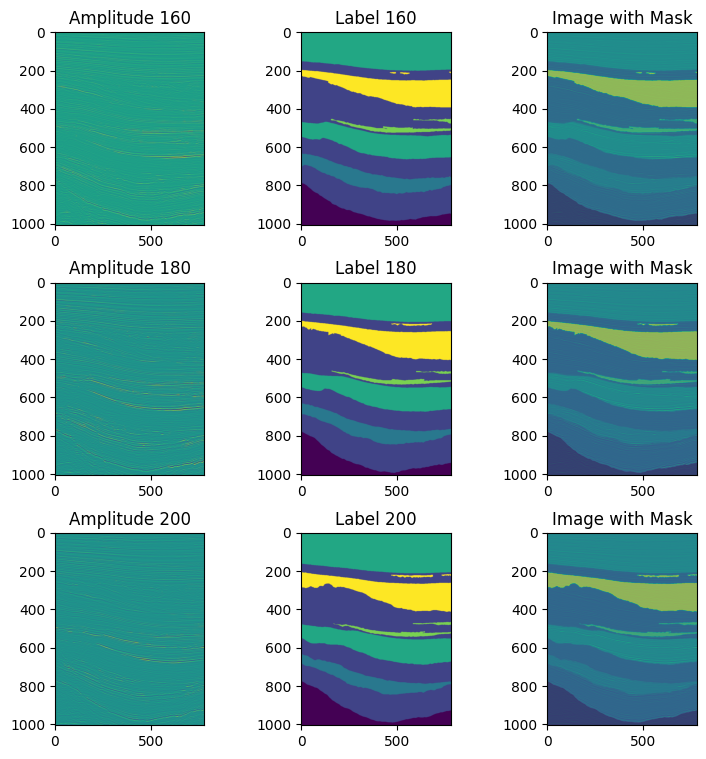

In [2]:
#@title Visualize samples of input and label image

names = ['160', '180', '200']
sample_slice_to_visualize = 'inline' # 'inline' or 'crossline'

if sample_slice_to_visualize == 'inline':
    data_images = [Image.open(os.path.join(INLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(INLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]
else:
    data_images = [Image.open(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]


transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in data_images])
y = torch.stack([transforms(image) for image in label_images])

print(x.shape, y.shape)

fig = plt.figure(figsize=(9, 9))
num_images = len(names)

for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(data_images[i])
    ax.set_title(SEISMIC_ATTRIBUTE_NAME + " " + names[i])

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(label_images[i])
    ax.set_title("Label " + names[i])

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

fig.subplots_adjust(hspace=0.3)
plt.show()

In [3]:
del data_images, label_images, x, y

In [4]:
#@title Splitting data for training and validation

# Data images = train
inline_train_paths = [] # 10.png, 100.png, 101.png, ..., 11.png
inline_val_paths = []
crossline_train_paths = []
crossline_val_paths = []

# Label
inline_train_label_paths = []
inline_val_label_paths = []
crossline_train_label_paths = []
crossline_val_label_paths = []

for i in ("data", "label"):
    # 1. Inline
    if i == "data":
        inline_image_names = [f for f in os.listdir(INLINE_DATA_IMAGES_PATH) if f.endswith('.png')]
    elif i == "label":
        inline_image_names = [f for f in os.listdir(INLINE_LABEL_IMAGES_PATH) if f.endswith('.png')]
    
    # 1.1. Training Images
    # inline_train_image_names = inline_train_image_label_names
    inline_train_image_names = [f for f in inline_image_names if \
                      int(f.split('.')[0]) >= inline_train_range[0] and \
                        int(f.split('.')[0]) <= inline_train_range[1]]

    if i == "data":
        for name in inline_train_image_names:
            inline_train_paths.append(os.path.join(INLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for name in inline_train_image_names:
            inline_train_label_paths.append(os.path.join(INLINE_LABEL_IMAGES_PATH, name))
    
    # 1.2. Validation Images
    # inline_val_image_names = inline_val_image_label_names
    inline_val_image_names = [f for f in inline_image_names if \
                      int(f.split('.')[0]) >= inline_val_range1[0] and \
                        int(f.split('.')[0]) <= inline_val_range1[1]]

    if i == "data":
        for f in inline_image_names:
            if int(f.split('.')[0]) >= inline_val_range2[0] and int(f.split('.')[0]) <= inline_val_range2[1]:
                inline_val_image_names.append(f)
        
        for name in inline_val_image_names:
            # inline_val_paths.append(os.path.abspath(os.path.join(INLINE_DATA_IMAGES_PATH, name)))
            inline_val_paths.append(os.path.join(INLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for f in inline_image_names:
            if int(f.split('.')[0]) >= inline_val_range2[0] and int(f.split('.')[0]) <= inline_val_range2[1]:
                inline_val_image_names.append(f)
        
        for name in inline_val_image_names:
            inline_val_label_paths.append(os.path.join(INLINE_LABEL_IMAGES_PATH, name))



    # 2. crossline
    if i == "data":
        crossline_image_names = [f for f in os.listdir(CROSSLINE_DATA_IMAGES_PATH) if f.endswith('.png')]
    elif i == "label":
        crossline_image_names = [f for f in os.listdir(CROSSLINE_LABEL_IMAGES_PATH) if f.endswith('.png')]
    
    # 2.1. Training Images
    # crossline_train_image_names = crossline_train_image_label_names
    crossline_train_image_names = [f for f in crossline_image_names if \
                      int(f.split('.')[0]) >= crossline_train_range[0] and \
                        int(f.split('.')[0]) <= crossline_train_range[1]]

    if i == "data":
        for name in crossline_train_image_names:
            crossline_train_paths.append(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for name in crossline_train_image_names:
            crossline_train_label_paths.append(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name))
    
    # 2.2. Validation Images
    # crossline_val_image_names = crossline_val_image_label_names
    crossline_val_image_names = [f for f in crossline_image_names if \
                      int(f.split('.')[0]) >= crossline_val_range1[0] and \
                        int(f.split('.')[0]) <= crossline_val_range1[1]]

    if i == "data":
        for f in crossline_image_names:
            if int(f.split('.')[0]) >= crossline_val_range2[0] and int(f.split('.')[0]) <= crossline_val_range2[1]:
                crossline_val_image_names.append(f)
        
        for name in crossline_val_image_names:
            # crossline_val_paths.append(os.path.abspath(os.path.join(crossline_DATA_IMAGES_PATH, name)))
            crossline_val_paths.append(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name))
    elif i == "label":
        for f in crossline_image_names:
            if int(f.split('.')[0]) >= crossline_val_range2[0] and int(f.split('.')[0]) <= crossline_val_range2[1]:
                crossline_val_image_names.append(f)
        
        for name in crossline_val_image_names:
            crossline_val_label_paths.append(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name))




# Merge inline and crossline
training_image_paths = inline_train_paths + crossline_train_paths
val_image_paths = inline_val_paths + crossline_val_paths

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(training_image_paths)}")
print(f"Number of validation samples: {len(val_image_paths)}")

# with open('./output/training-image-paths.txt', 'w') as f:
#     for i in training_image_paths:
#         f.write(i + '\n')

# with open('./output/val-image-paths.txt', 'w') as f:
#     for i in val_image_paths:
#         f.write(i + '\n')



training_label_paths = inline_train_label_paths + crossline_train_label_paths
val_label_paths = inline_val_label_paths + crossline_val_label_paths

# with open('./output/training-label-paths.txt', 'w') as f:
#     for i in training_label_paths:
#         f.write(i + '\n')

# with open('./output/val-label-paths.txt', 'w') as f:
#     for i in val_label_paths:
#         f.write(i + '\n')

Number of training samples: 1268
Number of validation samples: 103


In [5]:
del inline_image_names, inline_train_image_names, inline_train_paths, inline_val_image_names, inline_val_paths, crossline_image_names, crossline_train_image_names, crossline_train_paths, crossline_val_image_names, crossline_val_paths

In [8]:
#@title Utilities

class CustomDataset(Dataset):
    color_encoding = [
                ('a', (253, 231, 36)), # Gold
                ('b', (121, 209, 81)), # Light Green
                ('c', (68, 1, 84)), # Dark Purple
                ('d', (64, 67, 135)), # Medium Blue
                ('e', (34, 167, 132)), # Aquamarine
                ('f', (41, 120, 142)) # Cadet Blue
    ]

    def __init__(self, image_paths, label_paths, num_classes=NUM_CLASSES):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.num_classes = num_classes
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')

        image = self.transforms(image)
        resized_image = T.Resize(X_IMAGE_SIZE)(image)

        label = Image.open(self.label_paths[idx])
        label = label.convert('RGB')

        label = np.array(label)
        label = self.label_for_cross_entropy(label)
        label = Image.fromarray(label)
        resized_label = T.Resize(X_IMAGE_SIZE)(label)
        resized_label = np.array(resized_label)

        return resized_image, torch.from_numpy(resized_label).long()

    def label_for_cross_entropy(self, label):
        semantic_map = np.zeros(label.shape[:-1])
        semantic_map.fill(self.num_classes - 1)

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index

        return semantic_map

    def __len__(self):
        return len(self.label_paths)



def reverse_one_hot(image):
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)

    return x



# IoU Metric
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)

    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5

    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)



def val(model, dataloader):
    print('\n\n\t------- Start validating -------')
    accuracy_arr = []
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()

        val_loss_record = []

        for _, (val_data, val_label) in enumerate(dataloader):
            val_data_cuda = val_data.cuda()
            val_label_cuda = val_label.cuda()

            val_output = model(val_data_cuda)
            val_loss = loss_func(val_output, val_label_cuda)

            val_output = val_output.squeeze()
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())

            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)

            val_loss_record.append(val_loss.item())

        mean_accuracy = np.mean(accuracy_arr)

        miou_list = per_class_iu(hist)
        mean_iou = np.mean(miou_list)
        
        class_weight = hist.sum(axis=1) / hist.sum()
        weighted_iou = (class_weight[class_weight > 0] * miou_list[class_weight > 0]).sum()

        val_loss_mean = np.mean(val_loss_record)

        print('Mean validation loss: {}\nMean validation IoU: {}\nWeighted validation IoU: {}'.format(val_loss_mean, mean_iou, weighted_iou))
        
        return mean_accuracy, mean_iou, val_loss_mean

In [9]:
#@title Training and validation data preparation

train_dataset = CustomDataset(training_image_paths, training_label_paths)
val_dataset = CustomDataset(val_image_paths, val_label_paths)

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

158 steps per epoch


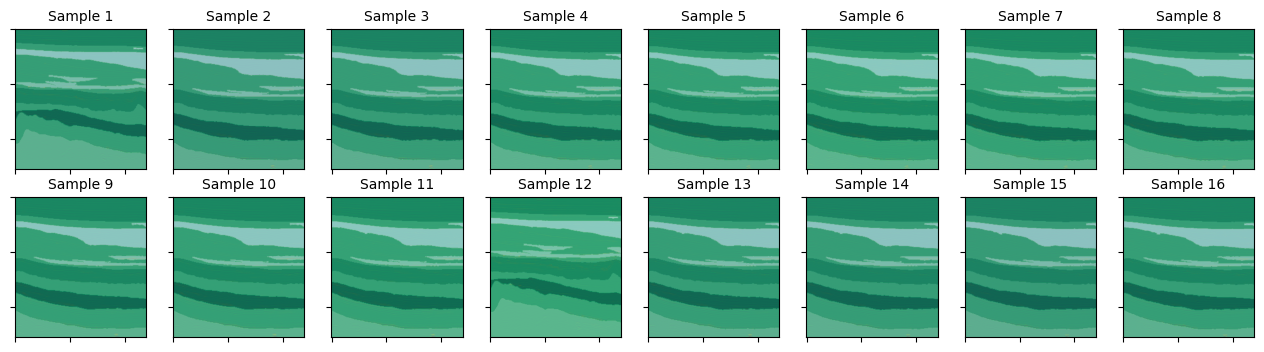

In [10]:
#@title Visualize training dataset

max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, label = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(label.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

plt.show()

In [11]:
del train_dataset, val_dataset

In [12]:
#@title Modeling

class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.activation = activation
        self.conv = nn.Conv2d(in_channels, filters, size, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)

        if self.activation:
            return F.relu(x)
        else:
            return x
        
        # return F.relu(self.norm(self.conv(x)))



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, size=3):
        super(ResidualBlock, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = ConvBlock(in_channels, filters, size)
        self.conv2 = ConvBlock(filters, filters, size, activation=False)

    def forward(self, x):
        x = F.relu(x)
        x = self.norm(x)
        x = self.conv1(x)
        x = self.conv2(x)

        return x



class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
        
    def forward(self, x1, x2):
        x = self.deconv(x1)

        # Padding if necessary
        diffY = x2.size()[2] - x.size()[2]
        diffX = x2.size()[3] - x.size()[3]
        x = F.pad(x, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2)) 

        x = torch.cat([x, x2], dim=1)

        return x



class UnetModel(nn.Module):
    def __init__(self, filters=16, dropout=0.5, num_classes=7, in_channel=1):
        super(UnetModel, self).__init__()

        # Encoder layers
        self.num_classes=num_classes

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )

        # Middle/Bottleneck layers
        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding=1),
            ResidualBlock(filters * 16, filters * 16),
            ResidualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )

        # Decoder layers
        self.deconv4 = DeconvBlock(filters * 16, filters * 8, 3)

        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )

        self.deconv3 = DeconvBlock(filters * 8, filters * 4, 2)

        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )

        self.deconv2 = DeconvBlock(filters * 4, filters * 2, 2)

        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.deconv1 = DeconvBlock(filters * 2, filters, 2)

        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, num_classes, 3, padding=1) # Output layer
        )

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        x = self.middle(conv4)
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)

        return x

In [13]:
#@title Training

torch.cuda.empty_cache()
model = UnetModel(num_classes=NUM_CLASSES, in_channel=3).to(device)
optimizer = torch.optim.Adam(model.parameters())



train_loss_hist = []
val_loss_hist = []

max_miou = 0
max_miou_epoch = 0
train_iou_hist = []
val_iou_hist = []

for epoch in range(EPOCHS):
    model.train()

    print()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()

        output = model(data)
        loss = loss_func(output, label)

        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        output = reverse_one_hot(output)
        output = np.array(output.cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)

    tq.close()
    loss_train_mean = np.mean(loss_record)
    train_loss_hist = train_loss_hist + [loss_train_mean]

    miou_list = per_class_iu(hist)
    mean_iou = np.mean(miou_list)
    train_iou_hist = train_iou_hist + [mean_iou]

    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))

    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), LATEST_MODEL_PATH)

    # Validate save best model
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(' *** Saving the best model with mIoU = {}'.format(mean_iou))
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/5: 100%|██████████| 1264/1264 [15:48<00:00,  1.33it/s, loss=0.380284]


loss for train : 0.673543
IoU for train : 0.364996


	------- Start validating -------


d:\Work\TEEP CVIT NCU\Work\Seismic\Codes\seismic-env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Work\TEEP CVIT NCU\Work\Seismic\Codes\seismic-env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean validation loss: 0.7838677351291363
Mean validation IoU: 0.5383781336469861
Weighted validation IoU: 0.638729643172839
 *** Saving the best model with mIoU = 0.5383781336469861



Epoch 2/5: 100%|██████████| 1264/1264 [16:07<00:00,  1.31it/s, loss=0.194274]


loss for train : 0.260501
IoU for train : 0.730098


	------- Start validating -------
Mean validation loss: 0.23055334503834063
Mean validation IoU: 0.7307782290483171
Weighted validation IoU: 0.8531480132933381
 *** Saving the best model with mIoU = 0.7307782290483171



Epoch 3/5: 100%|██████████| 1264/1264 [15:55<00:00,  1.32it/s, loss=0.152538]


loss for train : 0.175409
IoU for train : 0.806896


	------- Start validating -------
Mean validation loss: 0.23077975098903364
Mean validation IoU: 0.7797822176602213
Weighted validation IoU: 0.8615675496184031
 *** Saving the best model with mIoU = 0.7797822176602213



Epoch 4/5: 100%|██████████| 1264/1264 [15:52<00:00,  1.33it/s, loss=0.149255]


loss for train : 0.149509
IoU for train : 0.836714


	------- Start validating -------
Mean validation loss: 0.18958907860976
Mean validation IoU: 0.8014112123177429
Weighted validation IoU: 0.8801279641861197
 *** Saving the best model with mIoU = 0.8014112123177429



Epoch 5/5: 100%|██████████| 1264/1264 [15:40<00:00,  1.34it/s, loss=0.118180]


loss for train : 0.124125
IoU for train : 0.854913


	------- Start validating -------
Mean validation loss: 0.36854240756768447
Mean validation IoU: 0.7372049782338319
Weighted validation IoU: 0.812847281667841
Best mIoU: 0.8014112123177429 at epoch 4


In [14]:
del dataloader_train, dataloader_val, data, label, output

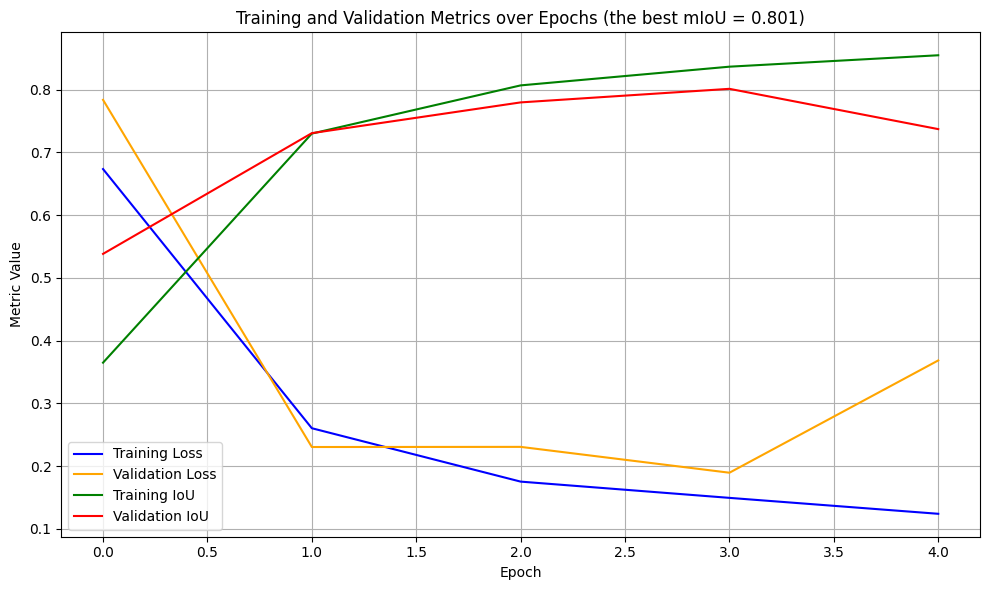

In [15]:
#@title Visualize Training and Validation Curve

plt.figure(figsize=(10, 6))

plt.plot(train_loss_hist, label='Training Loss', color='blue')
plt.plot(val_loss_hist, label='Validation Loss', color='orange')
plt.plot(train_iou_hist, label='Training IoU', color='green')
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title(f'Training and Validation Metrics over Epochs (the best mIoU = {max_miou:.3f})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PERFORMANCE_PATH, 'training-curve.png'))
plt.show()

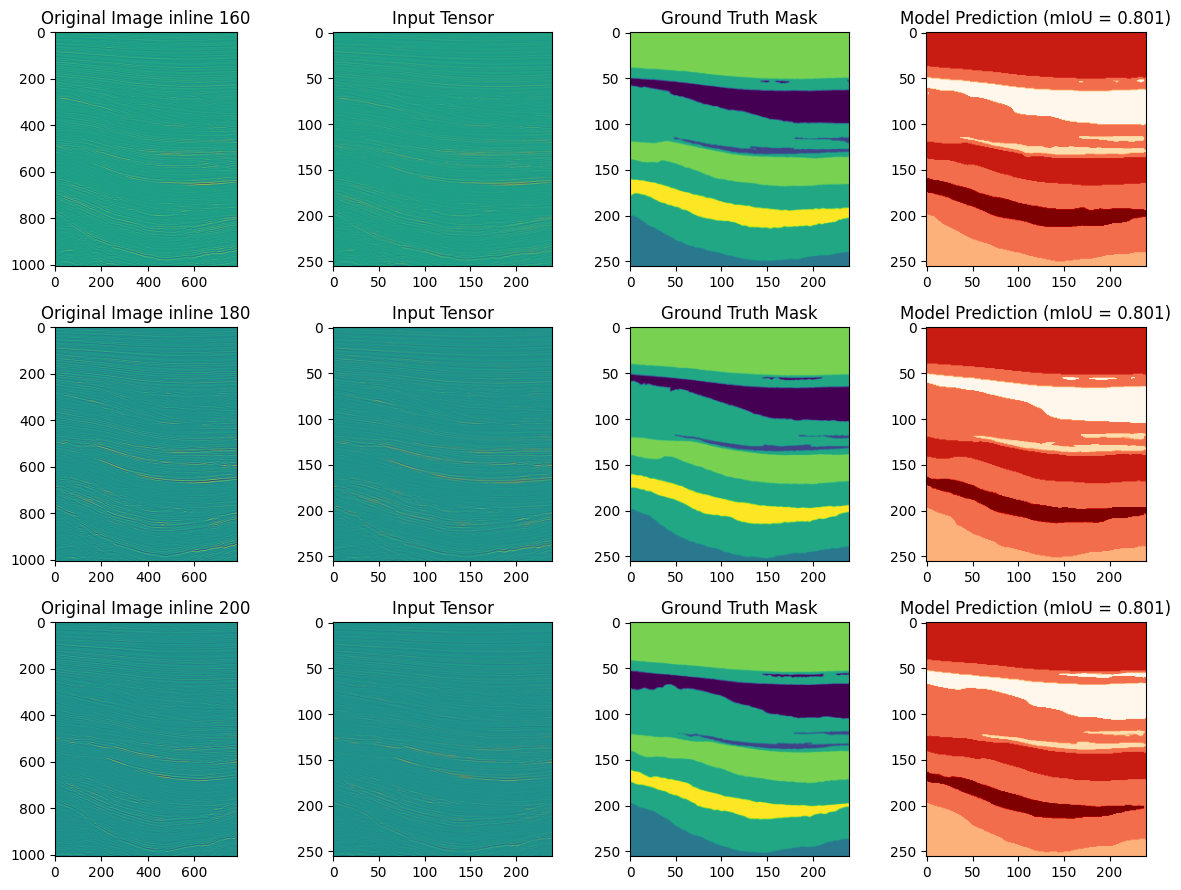

In [16]:
#@title Model Prediction on Sample Images

color_encoding = [
        ('a', (253, 231, 36)), # Gold
        ('b', (121, 209, 81)), # Light Green
        ('c', (68, 1, 84)), # Dark Purple
        ('d', (64, 67, 135)), # Medium Blue
        ('e', (34, 167, 132)), # Aquamarine
        ('f', (41, 120, 142)) # Cadet Blue
]

def label_for_cross_entropy(label):
    """
        Convert label image to matrix classes for apply cross entropy loss.
        Return semantic index, label in enumemap of H x W x class
    """
    semantic_map = np.zeros(label.shape[:-1])
    semantic_map.fill(NUM_CLASSES - 1)

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index

    return semantic_map


# Load Best Model
model = UnetModel(num_classes=NUM_CLASSES, in_channel=3).to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
torch.save(model.state_dict(), os.path.join(PERFORMANCE_PATH, BEST_MODEL_NAME))
model = model.to(device)
model.eval()

slice_to_visualize = 'inline' # 'inline' or 'crossline'
names = ['160', '180', '200']

if slice_to_visualize == 'inline':
    data_images = [Image.open(os.path.join(INLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(INLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]
else:
    data_images = [Image.open(os.path.join(CROSSLINE_DATA_IMAGES_PATH, name + '.png')) for name in names]
    label_images = [Image.open(os.path.join(CROSSLINE_LABEL_IMAGES_PATH, name + '.png')) for name in names]

data_images = [i.convert('RGB') for i in data_images]

label_images = [i.convert('RGB') for i in label_images]
label_images = [np.array(i) for i in label_images]
label_images = [label_for_cross_entropy(i) for i in label_images]
label_images = [Image.fromarray(i) for i in label_images]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize(X_IMAGE_SIZE)])
x = torch.stack([transforms(image) for image in data_images])
y = torch.stack([transforms(mask) for mask in label_images])

x = x.to(device)
outputs = model(x)
outputs =  outputs.squeeze()
outputs = np.array(outputs.detach().cpu())

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))

for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(data_images[i])
    ax.set_title(f'Original Image {slice_to_visualize} {names[i]}')

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    x_numpy = x[i].squeeze().cpu().numpy()
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    ax.imshow(x_numpy.squeeze())
    ax.set_title('Input Tensor')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze())
    ax.set_title('Ground Truth Mask')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    output = outputs[i].squeeze()
    output_tensor = torch.from_numpy(output)
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    ax.imshow(class_labels_np, cmap="OrRd")
    ax.set_title(f"Model Prediction (mIoU = {max_miou:.3f})")

plt.tight_layout()
plt.savefig(os.path.join(PERFORMANCE_PATH, 'prediction.png'))
plt.show()

In [17]:
del model, data_images, label_images, x, y, outputs